# 2층 신경망 함수 날코딩

In [3]:
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init=0.01):
        self.params = {}
        self.params['W1'] = np.random.randn(input_size,hidden_size) * weight_init
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = np.random.randn(hidden_size,output_size) * weight_init
        self.params['b2'] = np.zeros(output_size)
        print("2층 신경망[뉴런:{}개, 분류:{}개]이 생성되었습니다".format(hidden_size,output_size))

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def softmax(self, x):
        if x.ndim == 2:
            x = x.T
            x = x - np.max(x, axis=0)  #오버플로 대책
            y = np.exp(x) / np.sum(np.exp(x), axis=0)
            return y.T 
        x = x - np.max(x) #오버플로 대책
        return np.exp(x) / np.sum(np.exp(x))

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        k = np.dot(x, W1) + b1  #은닉1층
        k_prime = self.sigmoid(k)
        m = np.dot(k_prime, W2) + b2  #출력층(2층)
        n = self.softmax(m)
        return  n

    def cross_entropy_error(self, y, t):
        if y.ndim == 1:
            t = t.reshape(1, t.size)
            y = y.reshape(1, y.size)
        #훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
        if t.size == y.size:
            t = t.argmax(axis=1)
        batch_size = y.shape[0]
        return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

    def loss(self, x, t):
        y = self.predict(x)
        loss = self.cross_entropy_error(y, t)
        return loss

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        acc = np.sum(y==t) / x.shape[0]
        return acc

    def sigmoid_grad(self, x):
        return (1.0 - x) * x

    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        batch_num = x.shape[0]
        # forward(순전파)
        a1 = np.dot(x, W1) + b1  #은닉(1층), ①+②
        z1 = self.sigmoid(a1)  #③
        a2 = np.dot(z1, W2) + b2  #출력층(2층), ④+⑤
        y = self.softmax(a2)  #⑥
        # backward(역전파), 계산그래프를 활용한 미분(기울기) 구하기
        dy = (y - t) / batch_num  #오차함수의 도함수(예측값-정답), ⑥
        grads['W2'] = np.dot(z1.T, dy)  #2층 가중치 기울기 계산 및 갱신, ④
        grads['b2'] = np.sum(dy, axis=0)  #2층 바이어스 기울기 계산 및 갱신, ⑤
        da1 = np.dot(dy, W2.T)  #2층 역전파를 구현한 코드(기울기로 가중치 변경), ④
        dz1 = self.sigmoid_grad(z1) * da1  #1층 시그모이드 도함수의 값을 구현, ③
        grads['W1'] = np.dot(x.T, dz1)  #1층 가중치 기울기 계산, ①
        grads['b1'] = np.sum(dz1, axis=0)  #1층 바이어스 기울기 계산, ②
        return grads 

# 모델 훈련 및 테스트

In [23]:
# 입력값 생성
from tensorflow.keras.datasets.fashion_mnist import load_data
from tensorflow.keras.utils import to_categorical
import numpy as np
(x_train, y_train),(x_test, y_test) = load_data()
x_train = x_train.reshape(60000,784)/255
y_train = to_categorical(y_train, num_classes=10)
x_test = x_test.reshape(10000,784)/255
y_test = to_categorical(y_test, num_classes=10)

net = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)
train_loss_list = []
train_acc_list = []
test_acc_list = []
test_loss_list = []
learning_rate = 0.1
epochs = 30
from tqdm import tqdm, trange
for i in trange(600*epochs):
    batch_mask = np.random.choice(60000, 100)
    x_batch = x_train[batch_mask]
    t_batch = y_train[batch_mask]
    grad = net.gradient(x_batch, t_batch)
    for key in ['W1','b1','W2','b2']:
        net.params[key] -= learning_rate * grad[key]
    if i % 600 == 0:
        train_loss_list.append(net.loss(x_train, y_train))
        train_acc_list.append(net.accuracy(x_train, y_train))
        test_loss_list.append(net.loss(x_test, y_test))
        test_acc_list.append(net.accuracy(x_test, y_test))

2층 신경망[뉴런:50개, 분류:10개]이 생성되었습니다


100%|██████████| 18000/18000 [01:17<00:00, 231.52it/s]


In [24]:
print(test_acc_list)
print(test_loss_list)

[0.1, 0.6731, 0.7473, 0.7812, 0.8083, 0.8177, 0.8256, 0.8326, 0.835, 0.8339, 0.8388, 0.8423, 0.8445, 0.846, 0.8465, 0.8487, 0.8499, 0.8551, 0.8538, 0.8559, 0.8571, 0.8579, 0.8544, 0.8582, 0.8592, 0.8573, 0.8637, 0.8608, 0.8593, 0.8621]
[2.3031785266821188, 0.9059615994982209, 0.6744164121554349, 0.5901474449153575, 0.5401084853094295, 0.512346051118656, 0.4911346806506027, 0.47449566115666114, 0.46386763320376656, 0.46223042159094646, 0.4498422404243976, 0.4417548095240996, 0.4320523357648836, 0.42929880349314953, 0.429600393404714, 0.4223716538998501, 0.42093886843293604, 0.4106535839179108, 0.4108502832221877, 0.4051065501238967, 0.4043005668245532, 0.4006213024113852, 0.401944848903443, 0.39796065174751477, 0.39352062370158936, 0.39274287901835186, 0.38635227505909153, 0.38978868116983223, 0.3934647523943706, 0.386370345461926]


# 시각화

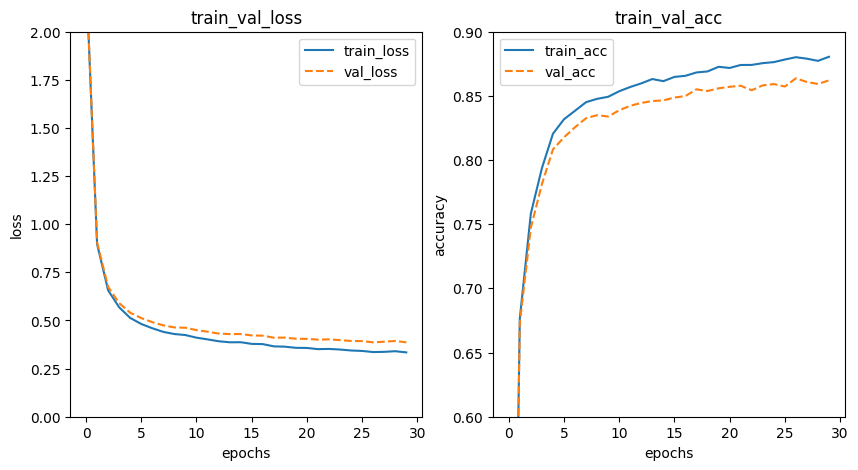

In [37]:
import matplotlib.pyplot as plt
plt.style.use(['default'])
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(train_loss_list, label='train_loss')
plt.plot(test_loss_list, label='val_loss', linestyle='--')
plt.title('train_val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 2)
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_acc_list, label='train_acc')
plt.plot(test_acc_list, label='val_acc', linestyle='--')
plt.title('train_val_acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.ylim(0.6, 0.9)
plt.show()

# 텐서플로우 모델과 비교

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
model = Sequential()
model.add(Dense(50, activation='relu', input_shape=(784, ))) #은닉층1층
model.add(Dense(10, activation='softmax')) #출력2층
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=30, batch_size=100)

Epoch 1/30
600/600 [==============================] - 2s 3ms/step - loss: 1.0825 - acc: 0.6732 - val_loss: 0.7617 - val_acc: 0.7491
Epoch 2/30
600/600 [==============================] - 2s 3ms/step - loss: 0.6651 - acc: 0.7836 - val_loss: 0.6399 - val_acc: 0.7826
Epoch 3/30
600/600 [==============================] - 2s 3ms/step - loss: 0.5828 - acc: 0.8069 - val_loss: 0.5838 - val_acc: 0.8008
Epoch 4/30
600/600 [==============================] - 2s 3ms/step - loss: 0.5407 - acc: 0.8185 - val_loss: 0.5605 - val_acc: 0.8049
Epoch 5/30
600/600 [==============================] - 2s 3ms/step - loss: 0.5147 - acc: 0.8253 - val_loss: 0.5367 - val_acc: 0.8123
Epoch 6/30
600/600 [==============================] - 2s 3ms/step - loss: 0.4967 - acc: 0.8313 - val_loss: 0.5253 - val_acc: 0.8159
Epoch 7/30
600/600 [==============================] - 2s 3ms/step - loss: 0.4822 - acc: 0.8352 - val_loss: 0.5089 - val_acc: 0.8228
Epoch 8/30
600/600 [==============================] - 2s 3ms/step - loss: 0.

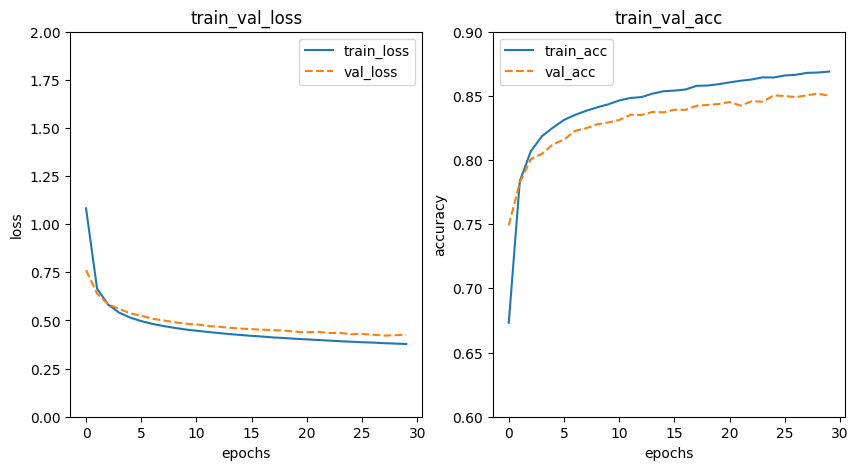

In [38]:
import matplotlib.pyplot as plt
his_dict = history.history
loss = his_dict['loss']
val_loss = his_dict['val_loss']
acc = his_dict['acc']
val_acc = his_dict['val_acc']

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(loss, label='train_loss')
plt.plot(val_loss, label='val_loss', linestyle='--')
plt.title('train_val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 2)
plt.legend()

plt.subplot(1,2,2)
plt.plot(acc, label='train_acc')
plt.plot(val_acc, label='val_acc', linestyle='--')
plt.title('train_val_acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.ylim(0.6, 0.9)
plt.show()